In [2]:
import sklearn
from sklearn import datasets  # Import datasets module
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn.linear_model import LinearRegression  # Import the LinearRegression class, for example
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load excel sheet which starts with channel_XX ( dynamic channel number)
excel_file = pd.ExcelFile('dv_2022_10_28_10_Zyklen_0_3V_dann_0_15V_Channel_24.xlsx')

# Get the sheet names in the Excel file
sheet_names = excel_file.sheet_names
# Initialize an empty DataFrame to store the data
channel_data = pd.DataFrame()
# Iterate through the sheet names
for sheet_name in sheet_names:
    #Check if the sheet name starts with 'channel'
    if sheet_name.startswith('Channel'):
        # Load the sheet into a DataFrame
        channel_data = excel_file.parse(sheet_name)
#clean emty rows where all the values are NaN
channel_data.dropna(how='all', inplace=True)
channel_data.head()

# create new dataframe with only the relevant columns
data = pd.DataFrame()
data = channel_data[['Step_Time(s)', 'Voltage(V)', 'Current(A)','Cycle_Index']]
data.head()

# Filtering the data for the first charging cycle
def filter_cycle(cycle_number, charging = True):
    cycle_data = data[data['Cycle_Index'] == cycle_number]
    if charging:
        return cycle_data[cycle_data['Current(A)'] > 0]
    return cycle_data[cycle_data['Current(A)'] < 0]

In [45]:
import numpy as np
from sklearn.model_selection import KFold

new = filter_cycle(1)

window_sizes = range(2, 1000)  # Adjust the range as needed

best_window_size = None
best_mse = float('inf')

for window_size in window_sizes:
    mse_sum = 0
    kf = KFold(n_splits=100)  # Adjust the number of folds as needed
    for train_index, test_index in kf.split(new):
        train_data = new.iloc[train_index]['Voltage(V)']
        test_data = new.iloc[test_index]['Voltage(V)']
        smoothed_data = train_data.rolling(window=window_size).mean().dropna()
        mse = ((smoothed_data - test_data).dropna() ** 2).mean()
        mse_sum += mse

    average_mse = mse_sum / 5  # Use the number of folds as the denominator
    if average_mse < best_mse:
        best_mse = average_mse
        best_window_size = window_size

print(f'Best Window Size: {best_window_size}')
#new['smoothed_data'] = new['Voltage(V)'].rolling(window=window_size).mean()




Best Window Size: None


In [ ]:
std_deviation = new['smoothed_data'].std()
tolerance_multiplier = 2  # You can adjust this multiplier
tolerance = std_deviation * tolerance_multiplier

#tolerance = 0.001  # Adjust this value based on your data
is_plateau = (new['smoothed_data'].diff().abs() <= tolerance)
plateau_indices = is_plateau.index[is_plateau]
plateau_segments = np.split(plateau_indices, np.where(np.diff(plateau_indices) != 1)[0] + 1)
plateau_ranges = [(segment[0], segment[-1]) for segment in plateau_segments]

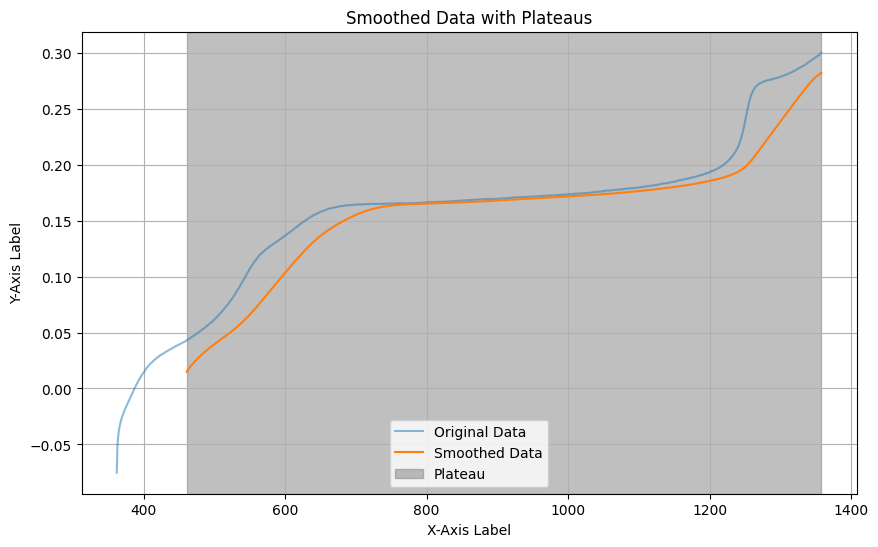

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(new['Voltage(V)'], label='Original Data', alpha=0.5)
plt.plot(new['smoothed_data'], label='Smoothed Data')
for start, end in plateau_ranges:
    plt.axvspan(start, end, color='gray', alpha=0.5, label='Plateau')
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Smoothed Data with Plateaus')
plt.legend()
plt.grid(True)
plt.show()

